In [1]:
from sumolib import checkBinary
import xml.etree.ElementTree as ET
import traci
import sys
import random
import numpy as np



In [2]:
POPULAION_SIZE = 20
INTERMEDIATE_SIZE = 40
MUTATION_PERCENTAGE = 10
NO_OF_GENERATIONS = 80
NO_OF_STEPS=8
NO_OF_LIGHTS=16

In [3]:
waiting_times_data = []
accidents_data = []

In [4]:
class TrafficLightPattern:
    
    def __init__(self):
        self.phenotype = []
        self.waiting_time = float('inf')
      
    def get_phenotype(self):
        return self.phenotype
    
    def set_phenotype(self, phenotype):
        self.phenotype = phenotype
    
    def set_waiting_time(self, waiting_time):
        self.waiting_time = waiting_time
    
    def get_waiting_time(self):
        return self.waiting_time
    

In [5]:
def phenotype(NO_OF_STEPS,NO_OF_LIGHTS):
    '''return phenotype '''
    phenotype = []
    m = ['G', 'g', 'y', 'r'] # start
    mr = [ 'y', 'r'] # digits after 'r'
    mg = ['G', 'g', 'y'] # digits after 'G' or 'g'
    # After y, it not give y again... then we can limit show yello continuously
    my = ['G', 'g','r'] # digits after 'y'
    for j in range(0,NO_OF_STEPS):
        s=""
        if j==0:
            for i in range(0,NO_OF_LIGHTS):
                s+=random.choice(m)
        else:
            for i in range(0,NO_OF_LIGHTS): 
                if phenotype[2*j-1][i]=='r':
                    s+=random.choice(mr)
                elif phenotype[2*j-1][i]=='y':
                    s+=random.choice(my)
                else:
                    s+=random.choice(mg)
        phenotype.append(3)
        phenotype.append(s)

    return phenotype

In [6]:
def simulate(program):
    '''return the waiting time after running the simulation'''
    
    traci.start([checkBinary(program), "-c", "sumo/map.sumocfg", "--tripinfo-output", "sumo/tripinfo.xml"])
    
    accidents = 0
    while traci.simulation.getMinExpectedNumber() > 0:
        traci.simulationStep()
        accidents += traci.simulation.getCollidingVehiclesNumber()
        
        
    traci.close()
    sys.stdout.flush()
    
    xmldoc = ET.parse('sumo/tripinfo.xml')

    tripinfos = xmldoc.findall('tripinfo')

    waiting_time = 0
    for tripinfo in tripinfos:
        waiting_time += float(tripinfo.get('waitingTime'))
        
    return waiting_time, accidents

In [7]:
def evaluate_pattern(phenotype):
    '''run the simulation after setting the new phenotype then return the waiting_time'''
    
    network = ET.parse('sumo/map.net.xml')
    signal = network.find('tlLogic') 
    
    i = 0
    for phase in signal.iter('phase'):
        
        duration = str(phenotype[2*i])
        if duration == "0":
             return float('inf'),0
        phase.set("duration", duration)
            
        state = phenotype[2*i+1]
        phase.set("state", state)
        i += 1
        
    network.write("sumo/map.net.xml")
    
    waiting_time,accidents = simulate('sumo')

    return waiting_time, accidents

In [8]:
def evaluate_population(population):
    times = []
    accident_list = []
    
    for pattern in population:
        waiting_time, accidents = evaluate_pattern(pattern.get_phenotype())
        pattern.set_waiting_time(waiting_time)
        times.append(waiting_time)
        accident_list.append(accidents)
        
    waiting_times_data.append(times)
    accidents_data.append(accident_list)

In [9]:
def create_new_population(population_size,NO_OF_STEPS,NO_OF_LIGHTS):
    
    population = []
    
    while (len(population) < population_size):
        light_pattern = TrafficLightPattern()
        phenotype_ = phenotype(NO_OF_STEPS,NO_OF_LIGHTS) 
        light_pattern.set_phenotype(phenotype_)
        if(not already_in(light_pattern, population)):
            population.append(light_pattern)
            
    return population


In [10]:
def crossover(pattern1,pattern2):
    #print("crossover")
    #print("pt1 - ",pattern1.get_phenotype())
    #print("pt2 - ",pattern2.get_phenotype())
    if pattern1.get_waiting_time()<pattern2.get_waiting_time():
        base_p = pattern1.get_phenotype().copy()
        other_p = pattern2.get_phenotype().copy()
    else:
        base_p = pattern2.get_phenotype().copy()
        other_p = pattern1.get_phenotype().copy()

    a = random.randint(0,len(base_p)/2-1)
    b = random.randint(0,len(base_p)/2-1)
    c = random.randint(0,len(base_p[1])-1)
    #print(a," ",b," ",c)
    #print(other_p)
    #print(base_p)
    # m=base_p[2*a+1]
    n=other_p[2*a+1]
    base_p[2*a+1]=n
    #print(base_p)
    
    x =  base_p[2*b+1]
    y = other_p[2*b+1]
    z = x[:c]+y[c:]
    base_p[2*b+1] = z
    #print(base_p)
    
    new_pattern = TrafficLightPattern()
    new_pattern.set_phenotype(base_p)  
    
    #print("pt1 - ",pattern1.get_phenotype())
    #print("pt2 - ",pattern2.get_phenotype())
    #print(new_pattern.get_phenotype())
    return new_pattern


In [11]:
def mutation(pattern):
    phenotype = pattern.get_phenotype().copy()
    a = random.randint(0,len(phenotype)/2-1)
    b = int(len(phenotype[1]))
    
    
    m = ['G', 'g', 'y', 'r'] # start
    mr = [ 'y', 'r'] # digits after 'r'
    mg = ['G', 'g', 'y'] # digits after 'G' or 'g'
    my = ['G', 'g','r'] # digits after 'y'
    
    s=""
    if a==0:
        for i in range(0,b):
            s+=random.choice(m)
    else:
        for i in range(0,b): 
            if phenotype[2*a-1][i]=='r':
                s+=random.choice(mr)
            elif phenotype[2*a-1][i]=='y':
                s+=random.choice(my)
            else:
                s+=random.choice(mg)
    phenotype[2*a+1]=s
    new_pattern = TrafficLightPattern()
    new_pattern.set_phenotype(phenotype)  
    
    return new_pattern

In [12]:
# def already_in(new_individual, population):
#     return next((True for elem in population if elem.get_phenotype()==new_individual.get_phenotype()), False)

In [13]:
def already_in(new_individual, population):
    for pop in population:
        if pop.get_phenotype()==new_individual.get_phenotype():
            #print(pop.get_phenotype())
            #print(new_individual.get_phenotype())
            return True
    else:
        return False

In [14]:
def select_candidates(population, size):
    population.sort(key = lambda x: x.get_waiting_time(), reverse=False)
    return population[0:size]

In [15]:
def next_generation(population, size, mutation_percentage):
    new_population = population
    print("New population")
    while(len(new_population)<size):
        print("new polpulation size = ",len(new_population))
        if (random.randint (1,100) > mutation_percentage):
            # do crossover 
            pattern1 = random.choice(new_population)
            pattern2 = random.choice(new_population)
            new_pattern = crossover(pattern1, pattern2)
            '''have to remake "already_in" '''
            if(not already_in(new_pattern,new_population)):
                new_population.append(new_pattern)
        else:
            # do mutation
            pattern = random.choice(new_population)
            new_pattern = mutation(pattern)
            if(not already_in(new_pattern,new_population)):
                new_population.append(new_pattern)
            
    return new_population

In [16]:
def controller():
    
    population = create_new_population(POPULAION_SIZE,NO_OF_STEPS,NO_OF_LIGHTS)
    
    for i in range(NO_OF_GENERATIONS):
        #print("Generation ",i," started")
        next_gen = next_generation(population, INTERMEDIATE_SIZE, MUTATION_PERCENTAGE)
        print("Generation ",i," started")
        evaluate_population(next_gen)
        population = select_candidates(next_gen,POPULAION_SIZE)
        print("Generation ",i," finished")
            
controller()

New population
new polpulation size =  20
new polpulation size =  21
new polpulation size =  22
new polpulation size =  23
new polpulation size =  24
new polpulation size =  25
new polpulation size =  26
new polpulation size =  27
new polpulation size =  28
new polpulation size =  29
new polpulation size =  30
new polpulation size =  31
new polpulation size =  32
new polpulation size =  33
new polpulation size =  34
new polpulation size =  35
new polpulation size =  36
new polpulation size =  37
new polpulation size =  38
new polpulation size =  39
Generation  0  started
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retryin

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  5  finished
New population
new polpulation size =  20
new polpulation size =  21
new polpul

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  10  finished
New population
new polpulation size =  20
new polpulation size =  21
new polpu

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  15  finished
New population
new polpulation size =  20
new polpulation size =  20
new polpu

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  20  finished
New population
new polpulation size =  20
new polpulation size =  20
new polpu

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  24  finished
New population
new polpulation size =  20
new polpulation size =  21
new polpulation size =  22
new polpulation size =  23
new polpulation size =  23
new polpulation size =  24
new polpulation size =  24
new polpulation size =  24
new polpulation size =  25
new polpulation size =  26
new polpulation size =  26
new polpulation size =  26
new polpulation size =  26
new polpulation size =  27
new polpulation size =  28
new polpulation size =  29
new polpulation size =  29
new polpulation size =  29
new polpulation size =  30
new polpulation size =  30
new polpulation size =  31
new polpulation size =  31
new polpulation size =  32
new polpulation size =  33
new polpulation size =  34
new polpulation size =  34
new polpulation size =  35
new polpulation size =  36
new polpulation size =  37
new polpulation size =  37
new polpulation size =  38
new polp

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  29  finished
New population
new polpulation size =  20
new polpulation size =  20
new polpulation size =  21
new p

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  33  finished
New population
new polpulation size =  20
new polpulation size =  20
new polpulation size =  20
new polpulation size =  21
new polpulation size =  21
new polpulation size =  22
new polpulation size =  22
new polpulation size =  22
new polpulation size =  23
new polpulation size =  24
new polpulation size =  24
new polpulation size =  24
new polpulation size =  24
new polpulation size =  24
new polpulation size =  24
new polpulation size =  24
new polpulation size =  24
new polpulation si

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  37  finished
New population
new polpulation size =  20
new polpulation size =  21
new polpulation size =  22
new polpulation size =  23
new polpulation size =  23
new polpulation size =  24
new polpulation size =  25
new polpulation size =  26
new polpulation size =  27
new polpulation size =  28
new polpulation size =  29
new polpulation size =  29
new polpulation size =  30
new polpulation size =  31
new polpulation size =  32
new polpulation size =  33
new polpulation size =  34
new polpulation size =  35
new polpulation size =  36
new polpulation size =  36
new polpulation size =  37
new polpulation size =  38
new polpulation size 

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  42  finished
New population
new polpulation size =  20
new polpulation size =  20
new polpu

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  46  finished
New population
new polpulation size =  20
new polpulation size =  20
new polpulation size =  21
new polpulation size =  21
new polpulation size =  22
new polpulation size =  23
new polpulation size =  23
new polpulation size =  24
new polpulation size =  24
new polpulation size =  24
new polpulation size =  24
new polpulation size =  24
new polpulation size =  24
new polpulation size =  25
new polpulation size =  26
new polpulation size =  27
new polpulation size =  28
new polpulation size =  29
new polpulation size =  29
new polpulation size =  29
new polpulation size =  29
new polpulation size =  29
new polpulation size =  30
new polpulation size =  30
new polpulation size =  31
new polpulation size =  31
new polpulation size =  32
new polpulation size =  33
new polpulation size =  33
new polpulation size =  34
new polpulation size =  35
new polp

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  51  finished
New population
new polpulation size =  20
new polpulation size =  20
new polpu

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  55  finished
New population
new polpulation size =  20
new polpulation size =  21
new polpulation size =  22
new polpulation size =  23
new polpulation size =  24
new polpulation size =  25
new polpulation size =  26
new polpulation size =  26
new polpulation size =  27
new polpulation size =  28
new polpulation size =  29
new polpulation size =  30
new polpulation size =  30
new polpulation size =  31
new polpulation size =  32
new polpulation size =  33
new polpulation size =  34
new polpulation size =  34
new polpulation size =  34
new polpulation size =  35
new polpulation size =  36
new polpulation size =  36
new polpulation size =  36
new polpulation size =  37
new polpulation size =  37
new polpulation size =  37
new polpulation size =  37
new polpulation size =  38
new polpulation size =  38
new polpulation size =  39
Generation  

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  60  finished
New population
new polpulation size =  20
new polpulation size =  20
new polpu

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  64  finished
New population
new polpulation size =  20
new polpulation size =  21
new polpulation size =  22
new polpulation size =  23
new polpulation size =  24
new polpulation size =  25
new polpulation size =  25
new polpulation size =  26
new polpulation size =  27
new polpulation size =  28


 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  68  finished
New population
new polpulation size =  20
new polpulation size =  20
new polpulation size =  21
new polpulation size =  22
new polpulation size =  23
new polpulation size =  24
new polpulation size =  25
new polpulation size =  25
new polpulation size =  26
new polpulation size =  26
new polpulation size =  27
new polpulation size =  27
new polpulation size =  27
new polpulation size =  28
new polpulation size =  29
new polpulation size =  30
new polpulation size =  30
new polpulation si

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  72  finished
New population
new polpulation size =  20
new polpulation size =  20
new polpulation size =  21
new polpulation size =  22
new polpulation size =  22
new polpulation size =  23
new polpulation size =  23
new polpulation size =  23
new polpulation size =  23
new polpulation size =  24
new polpulation size =  24
new polpulation size =  25
new polpulation size =  25
new polpulation size =  26
new polpulation size =  27
new polpulation size =  27
new polpulation size =  28
new polpulation size =  29
new polpulation size =  29
new polpulation size =  29
new polpulation size =  30
new polpulation size =  30
new polpulation size =  31
new polpulation size =  32
new polpulation size =  33
new polpulation size =  34
new polpulation size =  34
new polpulation size =  34
new polpulation size =  34
new polpulation size =  35
new polpulation size =  35
new polpulation size =  35
new polpulation size =  35


 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  77  finished
New population
new polpulation size =  20
new polpulation size =  21
new polpu

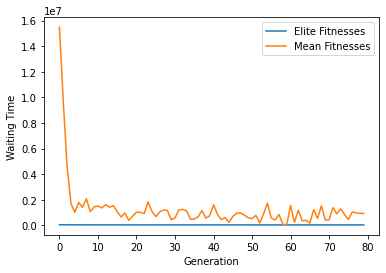

No handles with labels found to put in legend.


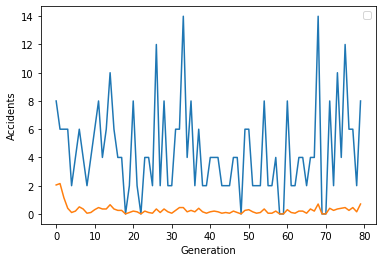

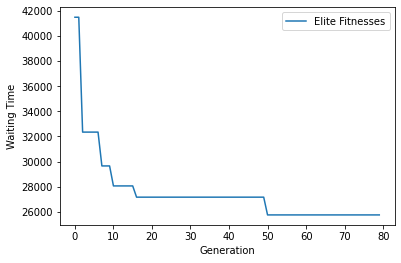

In [17]:
from statistics import mean, stdev
import matplotlib.pyplot as plt

'''Waiting time data'''

elite_fitnesses = []
mean_fitnesses = []
stdev_fitnesses = []

for i in waiting_times_data:
    elite_fitnesses.append(min(i))
    mean_fitnesses.append(mean(i))
    stdev_fitnesses.append(stdev(i))


plt.plot(elite_fitnesses,label='Elite Fitnesses')
plt.plot(mean_fitnesses,label='Mean Fitnesses')
# plt.plot(stdev_fitnesses,label='Standard Deviation')


plt.xlabel('Generation')
plt.ylabel('Waiting Time')
plt.legend()
plt.show()

'''Accident data'''

max_accidents = []
mean_accidents = []

for i in accidents_data:
    max_accidents.append(max(i))
    mean_accidents.append(mean(i))
    
plt.figure()

plt.plot(max_accidents)
plt.plot(mean_accidents)

plt.xlabel('Generation')
plt.ylabel('Accidents')
plt.legend()
plt.show()

'''Elite Graph'''

plt.figure()
plt.plot(elite_fitnesses,label='Elite Fitnesses')

plt.xlabel('Generation')
plt.ylabel('Waiting Time')
plt.legend()
plt.show()